In [1]:
import os
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
import matplotlib.pyplot as plt
import pickle


In [2]:
# Load the data

path = os.path.join(r'C:\Users\kentb\Desktop\PDM\data\products', 'BGCru_4000_6000.pkl')
file = open(path, "rb")
obs_data = pickle.load(file)
file.close()

In [3]:
# Define some helper functions for the peak finding

# Window power spectrum
from astropy.timeseries import LombScargle

def window_power_spectrum(time, min_freq, max_freq):
    '''Find the main peaks of the window power spectrum'''
    ls = LombScargle(time,1,fit_mean=False,center_data=False)
    freqW, powerW = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=10)
    return freqW, powerW

# Check the harmonics of the peaks

def check_harmonics(freq, power):
    '''Check the main peak and their harmonics.
    '''
    ok_indices = []
    # Check in the peak list if there are peaks close to each other and 
    # take the one with the highest power and delete the other one

    for idx, f in enumerate(freq):
        if not np.isclose(f, freq, rtol=0.05).any():
            ok_indices.append(idx)
        else:
            #get all indices of the peaks that are close to the current peak
            close_indices = np.where(np.isclose(f, freq, rtol=0.05))[0]
            #get the index of the peak with the highest power
            max_power_idx = np.argmax(power[close_indices])
            #append
            if close_indices[max_power_idx] not in ok_indices:
                ok_indices.append(close_indices[max_power_idx])

    freq = freq[ok_indices]
    power = power[ok_indices]

    main_peaks = np.array([])
    harmonics = np.array([])
    n = np.arange(2,7,1) # check for the first x harmonics
    for i in range(len(freq)):
        harmonic = 0
        main_peak = 0
        #print("i : ", i, "freq[i] : ", 1/freq[i])
        for j in range(i+1, len(freq)):
            #print("j : ", j, "freq[j] : ", 1/freq[j])
            for val in n:
                #print("val : ", val)
                if np.isclose(freq[i], freq[j]/val, rtol=0.05):
                    harmonic = freq[j]
                    main_peak = freq[i]
                    #print("harmonic : ", 1/harmonic, "main_peak : ", 1/main_peak)
                if harmonic != 0 and (harmonic not in harmonics):# and (np.isclose(harmonic, np.any(harmonics), rtol=0.05) == False):
                    harmonics = np.append(harmonics, harmonic)
                    #print("harmonics : ", 1/harmonics)
        if harmonic == 0:
            main_peak = freq[i]
        if (main_peak not in main_peaks) and (main_peak not in harmonics):# and (np.isclose(main_peak, np.any(main_peaks), rtol=0.05) == False):
            main_peaks = np.append(main_peaks, main_peak)
            #print("main_peaks : ", 1/main_peaks)
        #print("main_peaks : ", 1/main_peaks, "harmonics : ", 1/harmonics)
    return main_peaks, harmonics

# Find the peaks in the power spectrum 
from scipy.signal import find_peaks

def get_peaks(freq, power, threshold=0.1, distance=50):
    '''Find the peaks in the power spectrum'''
    #distance = 5*len(freq)/3000 # replace 3000 by self.baseline when put in class
    #threshold = ...              replace threshold p-value later.
    peaks, _ = find_peaks(power, height=threshold, distance=distance)
    freq_main_peaks, freq_harmonics = check_harmonics(freq[peaks], power[peaks])
    return freq_main_peaks, freq_harmonics

# Plotting the power spectrum with peaks(or not)

def plot_power_spectrum(freq, power, min_freq, max_freq, threshold=0.1,distance=50, peaks=False):
    fig, ax = plt.subplots(figsize=(16, 6))
    fig.subplots_adjust(bottom=0.2)
    ax.set_xscale('log')
    ax.plot(freq, power, '-k', rasterized=True)
    ax.set(xlabel=r'Frequency [$d^{-1}$]',
        ylabel=r'Window Power',
        xlim=(min_freq, max_freq));
    if peaks:
        main_peaks, harmonics = get_peaks(freq, power, threshold, distance)
        for peak in main_peaks:
            ax.axvline(peak, color='Blue', linestyle='--',label = f'True: {1/peak:.2f} d',alpha=0.5)
        for harmonic in harmonics:
            ax.axvline(harmonic, color='Red', linestyle='--',label = f'Harmonic: {1/harmonic:.2f} d',alpha=0.5)
        ax.axhline(threshold, color='Green', linestyle='-',label = f'Threshold: {threshold:.2f}',alpha=0.5)
        ax.legend(loc = 'upper right', fontsize = 8)
    plt.show()

In [4]:
window_freq, window_power = window_power_spectrum(obs_data.time_series.times, 1/800, 10)

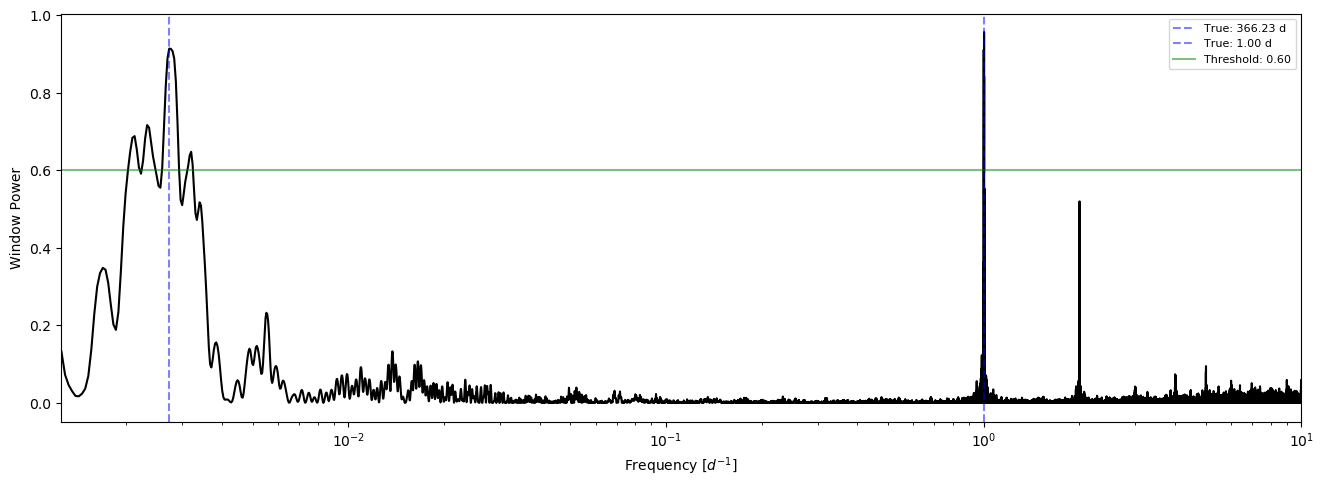

In [5]:
plot_power_spectrum(window_freq, window_power,min_freq=1/800,max_freq=10,threshold = 0.6,distance = 50, peaks=True)

not good... Need to find a better  way to find the peaks and to remove them.

Before cleaning peaks:  [366.23244663   0.9972623 ]
Entering window in get_peaks
window:  [array([366.23244663,   0.9972623 ]), array([], dtype=float64)]
Threshold:  0.024386020274597353
Before cleaning peaks:  [92.33716475 46.2571977   6.6851595   6.01747815  3.34304342  3.16730188
  3.00761263  2.84298691  2.00282556]
Entering not window in check_harmonics
Final peaks:  [array([46.2571977 ,  3.34304342,  2.00282556,  3.16730188,  3.00761263,
        2.84298691]), array([92.33716475,  6.6851595 ,  6.01747815])]
Before cleaning peaks:  [366.23244663   0.9972623 ]
Entering window in get_peaks
window:  [array([366.23244663,   0.9972623 ]), array([], dtype=float64)]
Threshold:  0.024386020274597353
Before cleaning peaks:  [9.49940875 6.6851595  5.15728654 4.26322307 3.50443507 3.34304342
 2.84298691 2.47306311 2.30909265]
Entering not window in check_harmonics
Final peaks:  [array([2.30909265, 2.47306311, 4.26322307, 3.34304342, 2.84298691]), array([9.49940875, 6.6851595 , 5.15728654])]


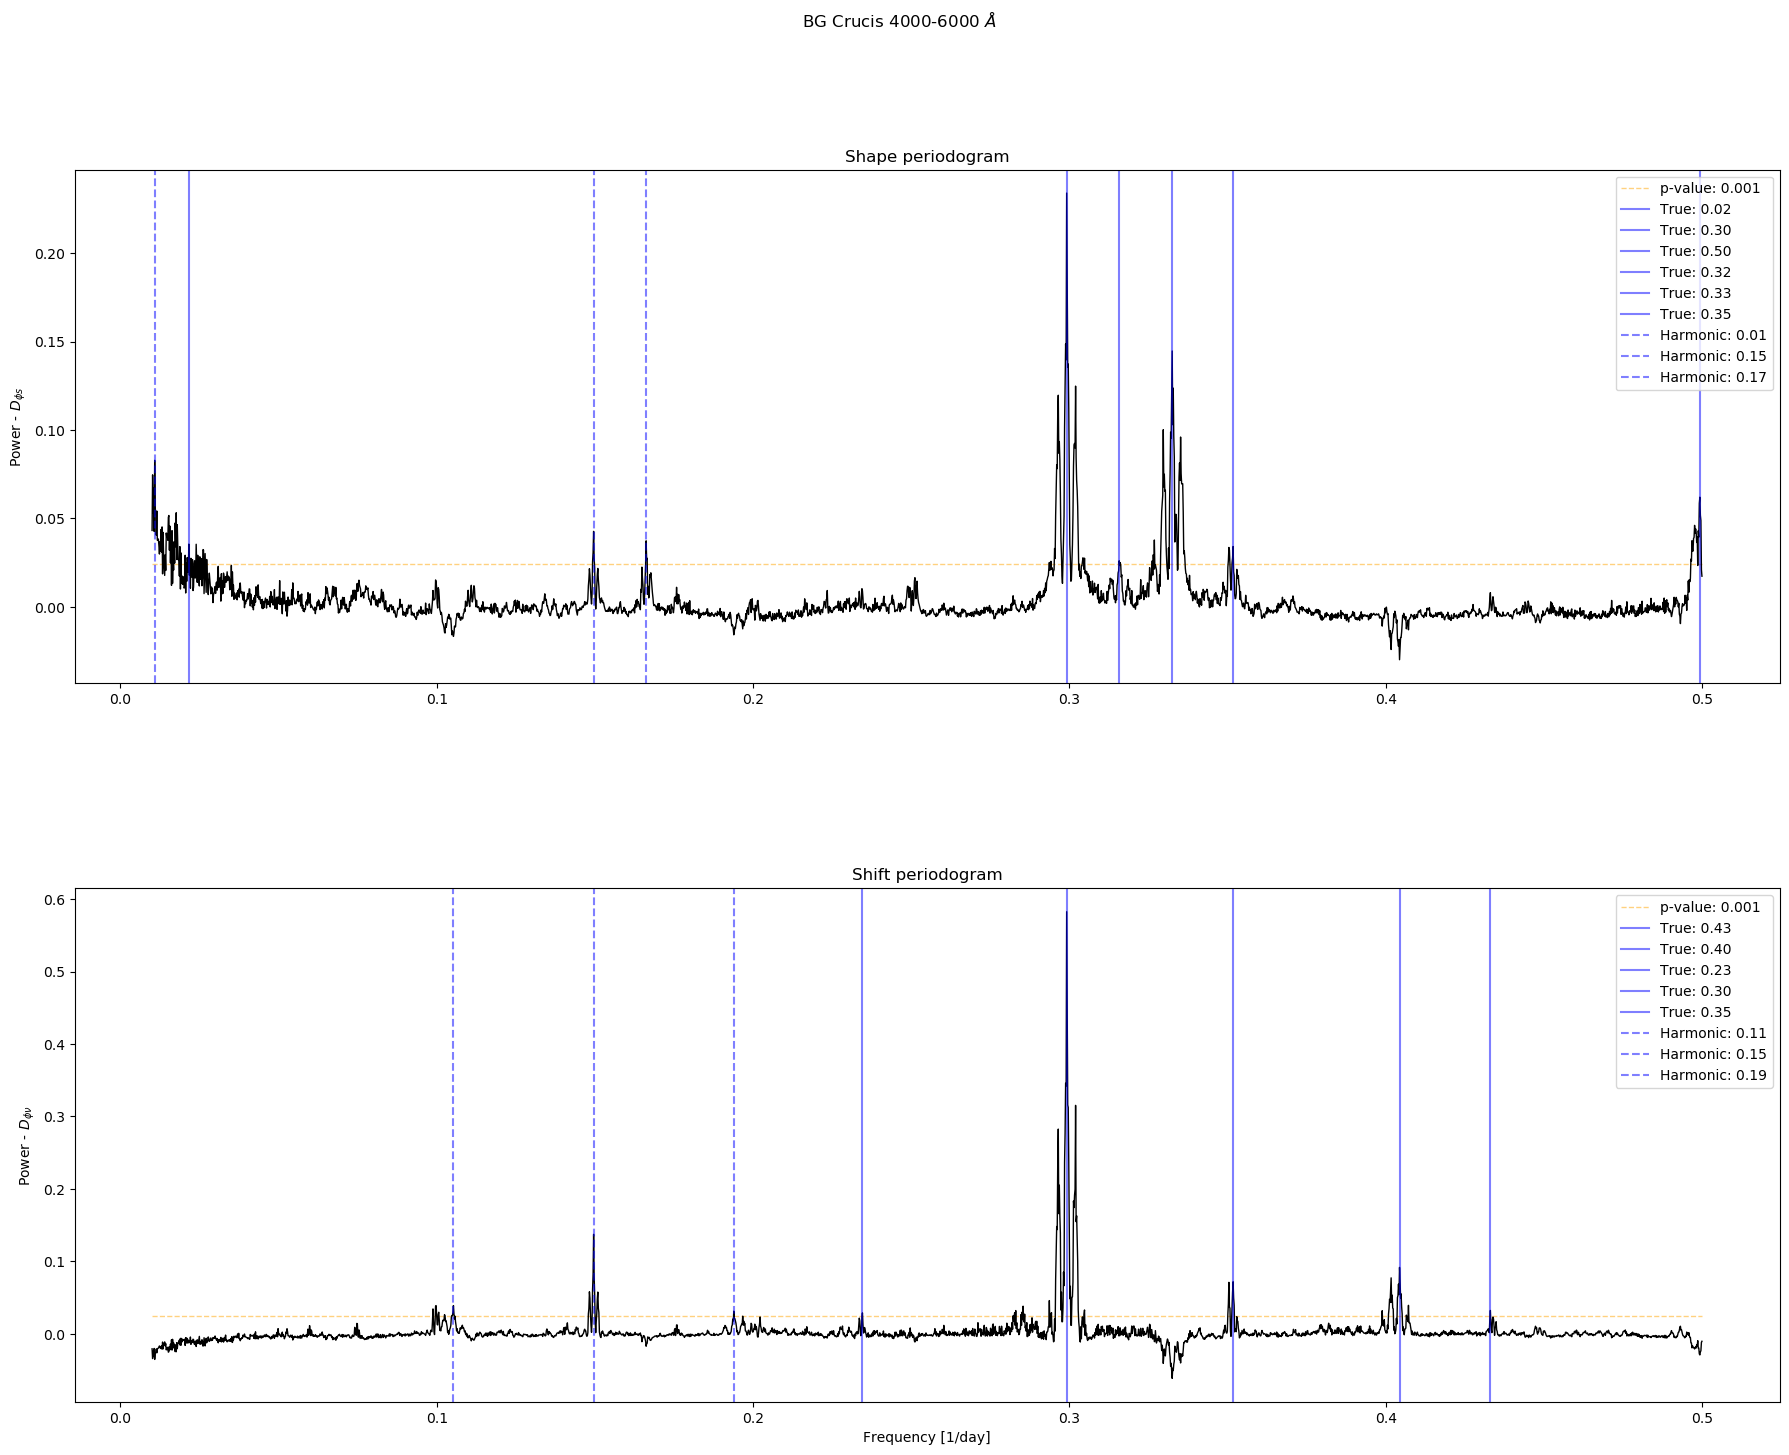

In [6]:
obs_data.periodicity_detector.plot_periodograms(annotate_pval=[1e-3], plot_rv=False,title=r"BG Crucis 4000-6000 $\AA$", log_scale=False, plot_peaks=True)

In [54]:
# Plot all periodograms in a single plot by opening each pickle file and adding a subplot

results_dir = "C:\\Users\\kentb\\Desktop\\PDM\\thesis\\main\\S1D\\results\\"
results_files = sorted([folder for folder in os.listdir(results_dir) if os.path.isfile(os.path.join(results_dir, folder))])

In [55]:
print(results_files)

['BGCru_4000_6000.pkl', 'BGCru_4200_4400.pkl', 'BGCru_4400_4600.pkl', 'BGCru_4600_4800.pkl', 'BGCru_4800_5000.pkl', 'BGCru_5000_5200.pkl', 'BGCru_5200_5400.pkl', 'BGCru_5400_5600.pkl', 'BGCru_5600_5800.pkl', 'BGCru_5800_6000.pkl', 'QZNor_4000_6000.pkl', 'QZNor_4200_4400.pkl', 'QZNor_4400_4600.pkl', 'QZNor_4600_4800.pkl', 'QZNor_4800_5000.pkl', 'QZNor_5000_5200.pkl', 'QZNor_5200_5400.pkl', 'QZNor_5400_5600.pkl', 'QZNor_5600_5800.pkl', 'QZNor_5800_6000.pkl', 'V0391_4000_6000.pkl', 'V0391_4200_4400.pkl', 'V0391_4400_4600.pkl', 'V0391_4600_4800.pkl', 'V0391_4800_5000.pkl', 'V0391_5000_5200.pkl', 'V0391_5200_5400.pkl', 'V0391_5400_5600.pkl', 'V0391_5600_5800.pkl', 'V0391_5800_6000.pkl']


In [ ]:
for file in results_files:
    file = open(results_dir + file, "rb")
    obs_data = pickle.load(file)
    obs_data.periodicity_detector.plot_periodograms(annotate_pval=[1e-2,1e-3], plot_vals=False,title=str(file).split('\\')[-1], log_scale=False)
    file.close()